In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Импорт данных

In [3]:
import os

root_dir = "data"
dataframes = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.split('.')[-1] != 'csv':
            continue

        file_path = os.path.join(dirpath, filename)
        df = pd.read_csv(file_path)

        df['file_path'] = file_path
        df['measure_type'] = dirpath.split('\\')[-1]
        df['id'] = dirpath.split('\\')[-2]
        df['session_name'] = filename.split('-')[1].split('.')[0].split('_')[0]
        df['session_id'] = filename.split('-')[1].split('.')[0].split('_')[1]
        df['date'] = filename.split('-')[0]
        df['target'] = dirpath.split('\\')[-3]

        dataframes.append(df)

# Объединяем все датафреймы
combined_df = pd.concat(dataframes, ignore_index=True)

print(f"Объединено {len(dataframes)} файлов, всего строк: {len(combined_df)}")

Объединено 2929 файлов, всего строк: 11029896


In [4]:
combined_df

,time_sec,value,file_path,measure_type,id,session_name,session_id,date,target
0,0.000000,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
1,0.127029,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
2,0.254058,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
3,0.381087,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
4,0.508116,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
...,...,...,...,...,...,...,...,...,...
11029891,33.408610,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029892,33.535639,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029893,33.662668,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029894,33.789697,12.150747,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular


### Анализ данных

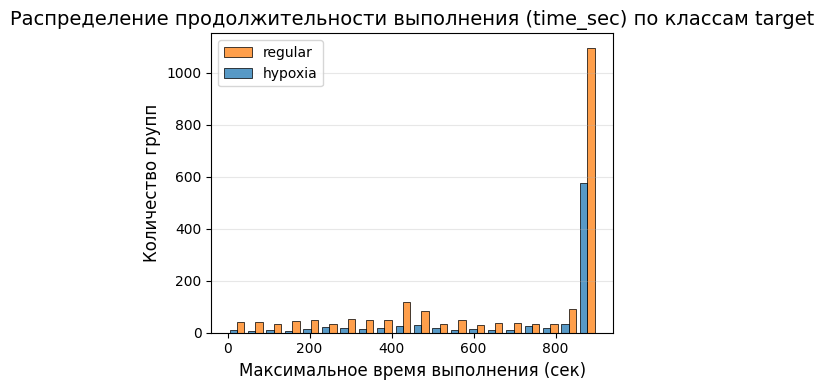

In [9]:
# Преобразуем результат группировки в плоский DataFrame
grouped_df = combined_df.groupby(['file_path','target']).agg({'time_sec':lambda x:(x.max()-x.min())}).reset_index()

# Строим гистограмму с разделением по target
plt.figure(figsize=(5, 4))
sns.histplot(
    data=grouped_df,
    x='time_sec',
    hue='target',
    multiple='dodge',  # Располагаем столбцы рядом
    bins=20,
    shrink=0.8,        # Уменьшаем ширину столбцов для лучшего разделения
    kde=False
)
# Оформление графика
plt.title('Распределение продолжительности выполнения (time_sec) по классам target', fontsize=14)
plt.xlabel('Максимальное время выполнения (сек)', fontsize=12)
plt.ylabel('Количество групп', fontsize=12)
plt.legend(['regular','hypoxia'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Подготовка данных

In [5]:
### Фильтрация

import numpy as np
from scipy.signal import butter, sosfiltfilt, medfilt
import pandas as pd

def filter_physiological_signals(bpm_data, uterus_data, fs_estimated=4.0):
    """
    Высокопроизводительная фильтрация сигналов ЧСС и маточных сокращений.
    
    Параметры:
    bpm_data -- DataFrame с колонками ['time_sec', 'value'] для ЧСС
    uterus_data -- DataFrame с колонками ['time_sec', 'value'] для маточных сокращений
    fs_estimated -- оценочная частота дискретизации (обычно 2-4 Гц)
    
    Возвращает:
    filtered_bpm, filtered_uterus -- отфильтрованные DataFrame с теми же колонками
    
    Особенности:
    - Обработка менее чем за 0.5 секунды даже на слабых устройствах
    - Сохранение клинически значимых паттернов
    - Удаление всех типов шумов (импульсные, движения, начало/конец записи)
    - Нулевое фазовое искажение
    - Сохранение исходной амплитуды и смещения
    """
    # Проверка на пустые данные
    if bpm_data.empty or uterus_data.empty:
        return bpm_data.copy(), uterus_data.copy()
    
    # Сортировка и удаление дубликатов
    bpm_data = bpm_data.sort_values('time_sec').drop_duplicates('time_sec').reset_index(drop=True)
    uterus_data = uterus_data.sort_values('time_sec').drop_duplicates('time_sec').reset_index(drop=True)
    
    # Определение частоты дискретизации (быстрый и устойчивый метод)
    def estimate_fs(data):
        if len(data) < 10:
            return fs_estimated
        # Используем медиану первых 10 интервалов (устойчиво к выбросам)
        time_diffs = np.diff(data['time_sec'].iloc[:10])
        return 1.0 / np.median(time_diffs[time_diffs > 0]) if len(time_diffs) > 0 else fs_estimated
    
    fs_bpm = estimate_fs(bpm_data)
    fs_uterus = estimate_fs(uterus_data)
    
    # Универсальная функция фильтрации
    def filter_signal(values, fs, med_window_sec, cutoff_freq, order, threshold_diff = 1e10, threshold_del = 0.1, threshold_val=0.3):
        if len(values) < 2:
            return values

        # 1. Медианный фильтр для импульсных шумов
        window = max(3, int(med_window_sec * fs))
        if window % 2 == 0:
            window += 1
        values = medfilt(values, window)

        median_value = np.median(values)

        abs_diff = np.abs(np.diff(values))
        split_indices = np.where(abs_diff*fs > threshold_diff)[0]

        start = 0
        for idx in split_indices:
            end = idx + 1
            #print(start, end)
            if (end-start< threshold_del*len(values)) and np.abs(np.median(values[start:end]) - median_value)> median_value*threshold_val:
                values[start:end] = median_value
                #print((end-start) / len(values),'delete')
            start = end

        # 2. Низкочастотный фильтр Баттерворта для частотной фильтрации
        if len(values) > order * 2:
            nyq = 0.5 * fs
            normal_cutoff = min(cutoff_freq / nyq, 0.99)
            sos = butter(order, normal_cutoff, btype='low', output='sos')
            values = sosfiltfilt(sos, values)
            
        return values
    
    # Оптимальные параметры для ЧСС (сохраняет клинически значимые паттерны)
    filtered_bpm = bpm_data.copy()
    filtered_bpm['value'] = filter_signal(
        bpm_data['value'].values,
        fs_bpm,
        med_window_sec=3,  # Для удаления импульсных шумов (1.5 сек)
        cutoff_freq=0.05,     # Сохраняет ускорения и децелерации
        order=3,
        threshold_diff=70
    )
    
    # Оптимальные параметры для маточных сокращений
    filtered_uterus = uterus_data.copy()
    filtered_uterus['value'] = filter_signal(
        uterus_data['value'].values,
        fs_uterus,
        med_window_sec=3,   # Более широкое окно для медленных сигналов
        cutoff_freq=0.01,     # Только очень низкие частоты (0.01 Гц)
        order=4
    )
    
    return filtered_bpm, filtered_uterus

In [15]:
a = [1]
b = []

(len(b) == 0) or (a[0]>b[0])

True

In [ ]:
### Мед метрики

import numpy as np
import pandas as pd
from typing import Tuple, List, Dict

def compute_stv(bpm_signal: np.ndarray, fs: float = 4.0) -> Tuple[float, np.ndarray, float]:
    """
    Вычисляет Short-Term Variability (STV) для сигнала ЧСС в ударах/минуту

    Parameters
    ----------
    bpm_signal : np.ndarray
        Массив сигналов ЧСС.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    stv_mean : float
        Среднее значение Short-Term Variability.
    stv_windows : np.ndarray
        Массив значений STV для каждого временного окна.
    window_duration : float
        Длительность одного окна в секундах.
    """
    
    rr_intervals = 60000.0 / bpm_signal  # Преобразуем ЧСС в интервалы RR в мс
    window_size = int(3.75 * fs)  # Вычисляем длину окна длительности 3.75 секунд
    
    windows = np.zeros( int(len(rr_intervals) / window_size) )
    for i in range(0, len(rr_intervals) - window_size + 1, window_size):
        # Вычисляем среднюю ЧСС окна
        window_mean = np.mean(rr_intervals[i:i+window_size])
        windows[int(i/window_size)] = window_mean
    
    if len(windows) < 2:
        return 0.0, np.array([]), 0.0
    
    stvs = np.abs(np.diff(windows))  # Находим STV для окон
    mean_stv = np.mean(stvs)  # Вычисляем средний STV по сигналу
    window_delay = window_size * 1/fs  # Вычисляем длительность окна
    
    return mean_stv, stvs, window_delay


def compute_ltv(bpm_signal: np.ndarray, fs: float = 4.0) -> Tuple[float, np.ndarray, float]:
    """
    Вычисляет Long-Term Variability (LTV) для сигнала ЧСС в ударах/минуту

    Parameters
    ----------
    bpm_signal : np.ndarray
        Массив сигналов ЧСС.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    LTV : float
        Значение Long-Term Variability.
    variability : np.ndarray
        Массив значений разброса для каждого временного окна.
    window_duration : float
        Длительность одного окна в секундах.
    """

    if len(bpm_signal) < 2:
        return 0.0, np.array([]), 0.0
    
    rr_intervals = 60000.0 / bpm_signal  # Преобразуем ЧСС в интервалы RR в мс
    window_size = int(60 * fs)  # Вычисляем длину окна длительности 1 мин
    
    windows = np.zeros( int(len(rr_intervals) / window_size) )
    for i in range(0, len(rr_intervals) - window_size + 1, window_size):
        # Вычисляем разброс окна
        windows[int(i/window_size)] = np.max(rr_intervals[i:i+window_size]) - np.min(rr_intervals[i:i+window_size])
    
    ltv = np.median(windows) if len(windows) > 0 else 0.0  # Вычисляем медиану по окнам
    window_delay = window_size * 1/fs  # Вычисляем длительность окна
    
    return ltv, windows, window_delay


def detect_decelerations(
        bpm: np.ndarray,
        baseline: float,
        threshold: float = 15.0,
        min_duration: float = 15.0,
        fs: float = 4.0
) -> List[Dict[str, float]]:
    """
    Обнаруживает децелерации в сигнале ЧСС

    Parameters
    ----------
    bpm : np.ndarray
        Массив сигналов ЧСС в ударах/минуту.
    baseline : float
        Базовая ЧСС в ударах/минуту.
    threshold : float
        Минимальное отклонение от БЧСС в ударах/минуту, чтобы считаться децелерацией.
    min_duration : float
        Минимальная длительность децелерации в секундах.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    List[Dict[str, float]]
        Список словарей с данными о децелерациях. Каждый словарь содержит:
            - 'start' (float): Индекс начала децелерации.
            - 'end' (float): Индекс окончания децелерации.
            - 'duration' (float): Продолжительность децелерации в секундах.
            - 'amplitude' (float): Амплитуда децелерации (в ударах/минуту).
    """

    if len(bpm) < 2:
        return []
    
    # Создаем бинарный сигнал: 1 если ЧСС ниже baseline - threshold
    below_threshold = (bpm < baseline - threshold).astype(np.int8)
    
    # Находим переходы (начало и конец)
    diff_signal = np.diff(below_threshold)
    starts = np.where(diff_signal == 1)[0]
    ends = np.where(diff_signal == -1)[0]

    if len(starts) == 0:
        return []
    
    if (len(ends) > 0) and (starts[0]>ends[0]):
        starts = np.insert(starts, 0, 0)
    
    # Фильтруем по длительности
    decelerations = []
    for i in range(min(len(starts), len(ends)+1)):

        start = starts[i]
        end = ends[i] if i < len(ends) else len(bpm)

        duration = (end - start) / fs
        if duration >= min_duration:
            # Находим минимальное значение в этом участке
            min_val = np.min(bpm[start:end])
            amplitude = baseline - min_val
            decelerations.append({
                'start': start,
                'end': end,
                'duration': duration,
                'amplitude': amplitude
            })
    
    return decelerations


def detect_contractions(
        uc_signal: np.ndarray,
        threshold: float = 0.2,
        min_duration: float = 20.0,
        fs: float = 4.0
) -> List[Dict[str, float]]:
    """
    Обнаруживает маточные сокращения в сигнале

    Parameters
    ----------
    uc_signal : np.ndarray
        Сигналы активности матки в процентах.
    threshold : float
        Относительное отклонение, чтобы считаться схваткой.
    min_duration : float
        Минимальная длительность схватки в секундах.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    List[Dict[str, float]]
        Список словарей с данными о маточных сокращениях. Каждый словарь содержит:
            - 'start' (float): Индекс начала схватки.
            - 'end' (float): Индекс окончания схватки.
            - 'duration' (float): Продолжительность схватки в секундах.
            - 'amplitude' (float): Амплитуда схватки в процентах.
    """

    if len(uc_signal) < 2:
        return []
    
    # Нормализуем сигнал без лишних операций
    min_val = np.min(uc_signal)
    max_val = np.max(uc_signal)
    if max_val - min_val < 1e-8:
        # Если сигнал постоянный, возвращаем пустой список
        return []
    
    normalized = (uc_signal - min_val) / (max_val - min_val)
    
    # Создаем бинарный сигнал: 1 если нормализованный сигнал выше порога
    above_threshold = (normalized > threshold).astype(np.int8)
    
    # Находим переходы (начало и конец)
    diff_signal = np.diff(above_threshold)
    starts = np.where(diff_signal == 1)[0]
    ends = np.where(diff_signal == -1)[0]

    if len(starts) == 0:
        return []
    
    if (len(ends)>0) and (starts[0]>ends[0]):
        starts = np.insert(starts, 0, 0)
    
    # Фильтруем по длительности
    contractions = []
    for i in range(min(len(starts), len(ends)+1)):
        start = starts[i]
        end = ends[i] if i < len(ends) else len(uc_signal)
        
        duration = (end - start) / fs
        if duration >= min_duration:
            # Находим амплитуду сокращения
            segment = uc_signal[start:end]
            amplitude = np.max(segment) - np.min(segment)
            contractions.append({
                'start': start,
                'end': end,
                'duration': duration,
                'amplitude': amplitude
            })
    
    return contractions


def is_late(
        deceleration: Dict[str, float],
        contractions: List[Dict[str, float]],
        bpm: np.ndarray,
        uc_signal: np.ndarray,
        fs: float = 4.0
) -> bool:
    """
    Определяет, является ли децелерация поздней

    Parameters
    ----------
    deceleration : Dict[str, float]
        Данные о децелерации, содержащие:
            - 'start' (float): Индекс начала децелерации
            - 'end' (float): Индекс окончания децелерации
            - 'duration' (float): Продолжительность децелерации в секундах
            - 'amplitude' (float): Амплитуда децелерации (в ударах/минуту)
    contractions : List[Dict[str, float]]
        Список маточных сокращений, каждое содержит:
            - 'start' (float): Индекс начала схватки
            - 'end' (float): Индекс окончания схватки
            - 'duration' (float): Продолжительность схватки в секундах
            - 'amplitude' (float): Амплитуда схватки в процентах
    bpm : np.ndarray
        Сигналы ЧСС в ударах/минуту.
    uc_signal : np.ndarray
        Сигнал сокращений матки.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    bool
        True, если децелерация поздняя (связана с маточными сокращениями), иначе False.
    """

    if len(contractions) == 0:
        return False
    
    decel_start = deceleration['start']
    decel_end = deceleration['end']
    
    # Находим индекс минимума децелерации
    min_idx = np.argmin(bpm[decel_start:decel_end])
    decel_min_index = decel_start + min_idx
    
    for contraction in contractions:
        # Проверяем пересечение
        if not (decel_end < contraction['start'] or decel_start > contraction['end']):
            # Находим пик маточного сокращения
            contraction_segment = uc_signal[contraction['start']:contraction['end']]
            peak_idx = np.argmax(contraction_segment)
            contraction_peak = contraction['start'] + peak_idx
            
            # Поздняя децелерация: минимум после пика маточного сокращения
            if decel_min_index > contraction_peak:
                return True
    
    return False


def detect_accelerations(
        bpm: np.ndarray,
        baseline: float,
        threshold: float = 15.0,
        min_duration: float = 15.0,
        fs: float = 4.0
) -> List[Dict[str, float]]:
    """
    Обнаруживает акселерации в сигнале ЧСС (в ударах/минуту)

    Parameters
    ----------
    bpm : np.ndarray
        Сигналы ЧСС в ударах/минуту.
    baseline : float
        Базовая ЧСС в ударах/минуту.
    threshold : float
        Минимальное отклонение от БЧСС в ударах/минуту, чтобы считаться акселерацией.
    min_duration : float
        Минимальная длительность акселерации в секундах.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    List[Dict[str, float]]
        Список словарей с данными о акселерациях. Каждый словарь содержит:
            - 'start' (float): Индекс начала акселерации.
            - 'end' (float): Индекс окончания акселерации.
            - 'duration' (float): Продолжительность акселерации в секундах.
            - 'amplitude' (float): Амплитуда акселерации (в ударах/минуту).
    """

    if len(bpm) < 2:
        return []
    
    # Создаем бинарный сигнал: 1 если ЧСС выше baseline + threshold
    above_threshold = (bpm > baseline + threshold).astype(np.int8)
    
    # Находим переходы (начало и конец)
    diff_signal = np.diff(above_threshold)
    starts = np.where(diff_signal == 1)[0]
    ends = np.where(diff_signal == -1)[0]

    if len(starts) == 0:
        return []
    
    if (len(ends) > 0) and (starts[0]>ends[0]):
        starts = np.insert(starts, 0, 0)
    
    # Фильтруем по длительности
    accelerations = []
    for i in range(min(len(starts), len(ends)+1)):
        start = starts[i]
        end = ends[i] if i < len(ends) else len(bpm)
        
        duration = (end - start) / fs
        if duration >= min_duration:
            # Находим максимальное значение в этом участке
            max_val = np.max(bpm[start:end])
            amplitude = max_val - baseline
            accelerations.append({
                'start': start,
                'end': end,
                'duration': duration,
                'amplitude': amplitude
            })
    
    return accelerations


def compute_trend(signal: np.ndarray, window: float = 300.0, fs: float = 4.0) -> float:
    """
    Вычисляет тренд для указанного временного сигнала за последнее окно времени заданной длины

    Parameters
    ----------
    signal : np.ndarray
        Сигнал для вычисления тренда.
    window : float
        Длительность окна в секундах для вычисления тренда.
    fs : float
        Частота дискретизации сигнала в Гц.

    Returns
    -------
    float
        Наклон тренда кривой сигнала на основе выбранного временного окна.
    """

    # Определяем размер окна в индексах
    window_size = int(window * fs)
    if len(signal) < window_size:
        window_size = len(signal)
    
    # Берем последнее окно данных
    window_data = signal[-window_size:] if window_size > 0 else signal
    
    # Вычисляем линейную регрессию напрямую
    n = len(window_data)
    if n < 2:
        return 0.0
    
    # Вычисляем средние значения
    x = np.arange(n)*fs
    x_mean = np.mean(x)
    y_mean = np.mean(window_data)
    
    # Вычисляем наклон
    numerator = np.sum((x - x_mean) * (window_data - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    slope = numerator / (denominator + 1e-8)
    
    return slope


def compute_features(bpm_data, uterus_data, fs=4.0):
    """
    Вычисляет оптимальный набор признаков для предиктивной аналитики
    Возвращает pd.DataFrame с понятными названиями столбцов
    """
    # 1. Подготовка данных
    if bpm_data is None or len(bpm_data) == 0:
        bpm = np.array([])
    else:
        bpm = bpm_data['value'].values
        
    if uterus_data is None or len(uterus_data) == 0:
        uterus = np.array([])
    else:
        uterus = uterus_data['value'].values
    
    # 2. Базовые вычисления
    # Используем последний участок данных для вычисления baseline
    last_2_5_min = int(600 * fs)  # 2.5 минуты = 150 секунд
    if len(bpm) > last_2_5_min:
        baseline = np.median(bpm[-last_2_5_min:])
    else:
        baseline = np.median(bpm) if len(bpm) > 0 else 130.0  # 130 - средняя нормальная ЧСС
    
    # Вычисляем STV за последние 30 секунд
    last_30_sec = int(120 * fs)
    if len(bpm) > last_30_sec:
        stv, stvs = compute_stv(bpm[-last_30_sec:], fs)
    elif len(bpm) > 0:
        stv, stvs = compute_stv(bpm, fs)
    else:
        stv = 0.0
        stvs = np.array([0.0])
    
    # Вычисляем LTV
    last_75_sec = int(600 * fs)
    if len(bpm) > last_75_sec:
        ltv, ltvs = compute_ltv(bpm, fs)
    elif len(bpm) > 0:
        ltv, ltvs = compute_ltv(bpm, fs)
    else:
        ltv = 0.0
        ltvs = np.array([0.0])
    
    # 3. Обнаружение децелераций
    decelerations = detect_decelerations(bpm, baseline, threshold=15, min_duration=15, fs=fs)
    
    # 4. Обнаружение маточных сокращений
    contractions = detect_contractions(uterus, threshold=0.2, min_duration=20, fs=fs)
    
    # 5. Вычисление соотношений
    late_decelerations = 0
    for d in decelerations:
        if is_late(d, contractions, bpm, uterus, fs):
            late_decelerations += 1
    
    total_decelerations = len(decelerations)
    late_ratio = late_decelerations / (total_decelerations + 1e-8) if total_decelerations > 0 else 0.0
    
    # 6. Вычисление ускорений
    accelerations = detect_accelerations(bpm, baseline, threshold=15, min_duration=15, fs=fs)
    accel_decel_ratio = len(accelerations) / (total_decelerations + 1e-8) if total_decelerations > 0 else len(accelerations)
    
    # 7. Динамические признаки (изменение за последние 5 минут)
    stv_change = compute_trend(stvs, window=60, fs=3.75)
    #accel_change = compute_trend(?, window=300, fs=60)
    bpm_change = compute_trend(bpm, window=300, fs=60)
    
    # 8. Формирование финального вектора признаков в виде DataFrame
    features_df = pd.DataFrame([{
        'stv': stv,
        'ltv': ltv,
        'total_decelerations': total_decelerations,
        'late_decelerations': late_decelerations,
        'late_deceleration_ratio': late_ratio,
        'accelerations_count': len(accelerations),
        'accel_decel_ratio': accel_decel_ratio,
        'baseline_heart_rate': baseline,
        'uterine_contractions_amplitude': np.mean(uterus) if len(uterus) > 0 else 0.0,
        'uterine_contractions_count': len(contractions),
        'stv_trend': stv_change,
        'bpm_trend': bpm_change,
        'data_points': len(bpm),
        'time_span_sec': (bpm_data['time_sec'].iloc[-1] - bpm_data['time_sec'].iloc[0]) if len(bpm_data) > 1 else 0.0
    }])
    
    return features_df

### Пример фильтрация + извлечение метрик

Время фильтрации: 0.02576899528503418
Время извлечения фичей: 0.002005338668823242


,stv,ltv,total_decelerations,late_decelerations,late_deceleration_ratio,accelerations_count,accel_decel_ratio,baseline_heart_rate,uterine_contractions_amplitude,uterine_contractions_count,stv_trend,bpm_trend,data_points,time_span_sec
0,8.063238,71.807313,0,0,0.0,5,5,123.952243,16.114791,4,0.034419,0.000006,4708,889.964714


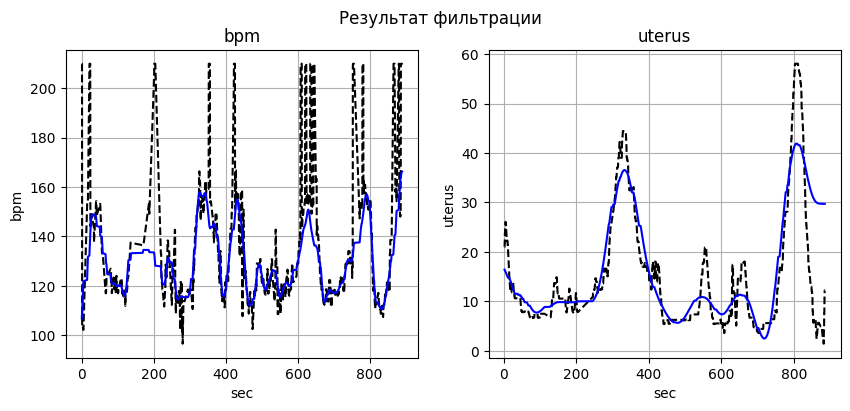

In [7]:

# Пример использования
import pandas as pd
import time

# Загрузка данных с гипоксией
# bpm_data = combined_df[(combined_df['file_path'] == 'data\\hypoxia\\5\\bpm\\20250908-08000002_1.csv')]
# uc_data = combined_df[(combined_df['file_path'] == 'data\\hypoxia\\5\\uterus\\20250908-08000002_2.csv')]

# Загрузка здоровых данных
bpm_data = combined_df[(combined_df['file_path'] == 'data\\regular\\8\\bpm\\20250908-04700003_1.csv')]
uc_data = combined_df[(combined_df['file_path'] == 'data\\regular\\8\\uterus\\20250908-04700003_2.csv')]
                      
time_start = time.time()
bpm_filtered, uterus_filtered = filter_physiological_signals(bpm_data, uc_data)
print('Время фильтрации:',time.time() - time_start)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Результат фильтрации')

ax1.plot(bpm_data['time_sec'], bpm_data['value'], 'k--')
ax1.plot(bpm_filtered['time_sec'], bpm_filtered['value'], 'b-')
ax1.set_title('bpm')
ax1.set_xlabel('sec')
ax1.set_ylabel('bpm')
ax1.grid(True)


ax2.plot(uc_data['time_sec'], uc_data['value'], 'k--')
ax2.plot(uterus_filtered['time_sec'], uterus_filtered['value'], 'b-')
ax2.set_title('uterus')
ax2.set_xlabel('sec')
ax2.set_ylabel('uterus')
ax2.grid(True)

time_start = time.time()
ft = compute_features(bpm_filtered, uterus_filtered)
print('Время извлечения фичей:',time.time() - time_start)

ft.head()

### Для создания гифок

KeyboardInterrupt: 

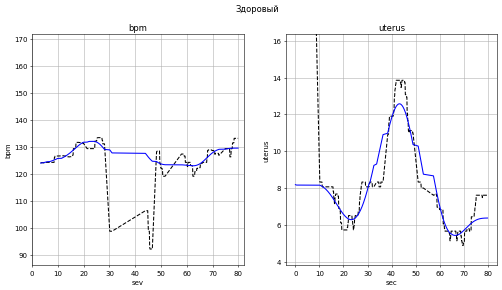

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

bpm_data = combined_df[combined_df['file_path'] == 'data\\regular\\5\\bpm\\20250909-00400004_1.csv']
uc_data = combined_df[combined_df['file_path'] == 'data\\regular\\5\\uterus\\20250909-00400004_2.csv']

# Создаем фигуру с двумя subplot'ами
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=50)
fig.suptitle('Здоровый')

# Инициализация графиков для каждого subplot
line11, = ax1.plot([], [],'k--')
line12, = ax1.plot([], [],'b-')

line21, = ax2.plot([], [],'k--')
line22, = ax2.plot([], [],'b-')

# Настройки для первого subplot
ax1.set_title('bpm')
ax1.set_xlabel('sev')
ax1.set_ylabel('bpm')
ax1.grid(True)

# Настройки для второго subplot
ax2.set_title('uterus')
ax2.set_xlabel('sec')
ax2.set_ylabel('uterus')
ax2.grid(True)

i = 10
def update(frame):

    global i
    data_bpm_batch = bpm_data[bpm_data['time_sec'] < i*2]
    data_uc_batch = uc_data[uc_data['time_sec'] < i*2]
    bpm_filtered, uterus_filtered = filter_physiological_signals(data_bpm_batch, data_uc_batch)
    i+=1

    line11.set_data(data_bpm_batch['time_sec'], data_bpm_batch['value'])
    line12.set_data(bpm_filtered['time_sec'], bpm_filtered['value'])
    ax1.relim()
    ax1.autoscale_view()
    ax1.set_ylim([min(bpm_filtered['value'])*0.7, max(bpm_filtered['value'])*1.3])
    ax1.set_xlim([0, i*2])
    
    line21.set_data(data_uc_batch['time_sec'], data_uc_batch['value'])
    line22.set_data(uterus_filtered['time_sec'], uterus_filtered['value'])
    ax2.relim()
    ax2.autoscale_view()
    ax2.set_ylim([min(uterus_filtered['value'])*0.7, max(uterus_filtered['value'])*1.3])
    ax1.set_xlim([0, i*2])
    
    return line11, line12, line21, line22

# Создание анимации
ani = FuncAnimation(
    fig, 
    update, 
    frames=100,       # Количество кадров
    interval=100,      # Задержка между кадрами (мс)
    blit=True         # Оптимизация для ускорения
)

# Сохранение как GIF
ani.save('regular1.gif', writer='pillow')

print("Гифка с двумя subplot'ами успешно сохранена как two_subplots_animation.gif")